# Metric: Traffic Congestion Per Neighborhood
---

In [2]:
#Import all necesities to read and display the data
import pandas as pd
import geopandas
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 

Traffic is a key factor in determining which neighborhood would be best suited for playing Mario Kart. High traffic congestion will only slow us down and make it impossible to get a good placement in the race. In choosing a neighborhood we will be looking for neighborhoods with the least traffic flow, allowing us for easy usage of the roads, with no competition. 

In [3]:
#Create initial file for reading the traffic data
TrafficCount = pd.read_csv("CSV/TrafficCount.csv")

#Display initial table for the data
TrafficCount.head()

id  device_id    record_oid count_start_date count_end_date  \
0  1011743669         85  1.445865e+09       2019-04-18     2019-04-26   
1  1026101993        140  1.121444e+09       2019-01-24            NaN   
2  1032382575         11  1.539893e+09       2018-08-28     2018-09-04   
3   103627606          9  7.341951e+08       2018-07-17     2018-08-01   
4  1039546167        144           NaN              NaN            NaN   

   average_daily_car_traffic  average_daily_bike_traffic counter_number  \
0                     4949.0                         NaN              6   
1                        NaN                         NaN            NaN   
2                        NaN                         NaN            NaN   
3                     2741.0                         NaN            NaN   
4                        NaN                         NaN            NaN   

         counter_type  speed_limit  ...  longitude   latitude  \
0            StatTrak         25.0  ... -79.967772  40.455733   
1  Intersection Study          NaN  ... -79.952249  40.466157   
2                 NaN         35.0  ... -80.076469  40.460717   
3            StatTrak         25.0  ... -79.914335  40.437379   
4                 NaN          NaN  ... -80.019211  40.490794   

            neighborhood  council_district  ward        tract  \
0            Polish Hill               7.0   6.0  42003060500   
1  Central Lawrenceville               7.0   9.0  42003090200   
2                Windgap               2.0  28.0  42003563000   
3    Squirrel Hill South               5.0  14.0  42003140800   
4            Perry North               1.0  26.0  42003260200   

   public_works_division pli_division  police_zone  fire_zone  
0                    6.0          6.0          2.0        2-6  
1                    2.0          9.0          2.0        3-6  
2                    5.0         28.0          6.0       1-16  
3                    3.0         14.0          4.0       2-18  
4                    1.0         26.0          1.0       1-15  

[5 rows x 25 columns]

In [4]:
#Create a table that has each neighborhood with their daily car traffic
TrafficCountPerNeighborhood = TrafficCount[["neighborhood", "average_daily_car_traffic"]]
TrafficCountPerNeighborhood.head()

neighborhood  average_daily_car_traffic
0            Polish Hill                     4949.0
1  Central Lawrenceville                        NaN
2                Windgap                        NaN
3    Squirrel Hill South                     2741.0
4            Perry North                        NaN

In [5]:
#We have multiple averages for different neighborhoods, so we want to combine them all together and average their averages
AverageTPN = TrafficCountPerNeighborhood.groupby("neighborhood").mean()

AverageTPN = AverageTPN.rename(columns = {"average_daily_car_traffic" : "Average Daily Car Traffic"})
AverageTPN.head()

Average Daily Car Traffic
neighborhood                               
Allegheny Center                2386.000000
Allegheny West                   477.000000
Arlington                       2285.500000
Banksville                              NaN
Beechview                       1418.333333

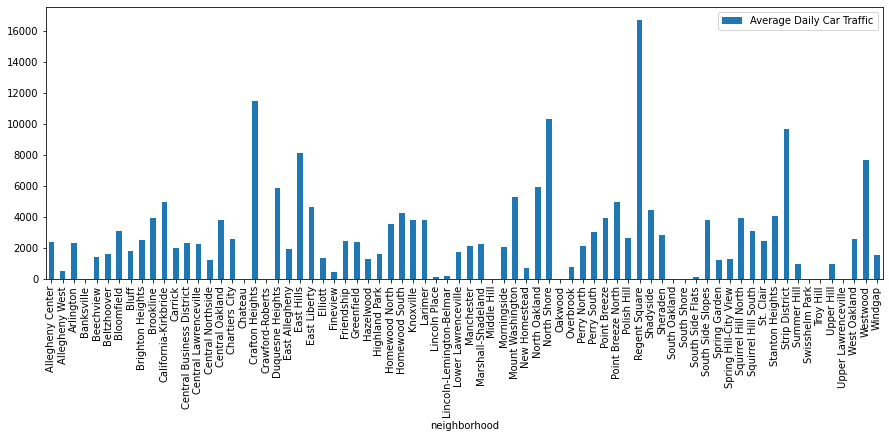

In [6]:
#Lets graph this out with a bar graph to see some inital findings
AverageTPN.plot.bar(figsize=(15,5))

As we can see here some neighborhoods have extremely high traffic flows, and others have none. The areas with no traffic flow are most likely caused by a lack of tracking data, but some of the high value areas are not caused solely by high congestion, but because of the amount of people living there.

In [7]:
#Import data set for population
Population = pd.read_csv("CSV/total-population.csv")
Population = Population[["Neighborhood", "Estimate; Total"]]

#Rename for clarification
Population = Population.rename(columns = {"Estimate; Total" : "Total Population"})
AverageTPN = AverageTPN.reset_index()
AverageTPN = AverageTPN.rename(columns = {"neighborhood" : "Neighborhood"})

Population.sample(5)

Neighborhood  Total Population
8                 Beltzhoover            1702.0
40             Homewood North            3371.0
79            Stanton Heights            4761.0
16  Central Business District            4060.0
60                  Overbrook            3682.0

In [8]:
#Merge the two dataframes to become one table
TrafficAndPop = AverageTPN.merge(Population, how="right", on="Neighborhood")
TrafficAndPop.head()

Neighborhood  Average Daily Car Traffic  Total Population
0  Allegheny Center                2386.000000            1411.0
1    Allegheny West                 477.000000             343.0
2         Arlington                2285.500000            1852.0
3        Banksville                        NaN            3858.0
4         Beechview                1418.333333            8078.0

Now that we have the populaton and traffic flow in one dataframe, we can divide the two and multiply by 12 (because there are 12 racers in each race) to get the average car flow per 12 people.

In [9]:
#Now let's create a new column for the flow per 12 people
TrafficAndPop["Traffic Flow Per 12 People"] = TrafficAndPop["Average Daily Car Traffic"] / TrafficAndPop["Total Population"] * 12
TrafficAndPop.sample(5)

Neighborhood  Average Daily Car Traffic  Total Population  \
47        Perry North                2123.777778            3771.0   
24            Elliott                1342.666667            2491.0   
51        Polish Hill                2649.000000            1331.0   
11            Carrick                1969.571429           10122.0   
75  Arlington Heights                        NaN             272.0   

    Traffic Flow Per 12 People  
47                    6.758243  
24                    6.468085  
51                   23.882795  
11                    2.334999  
75                         NaN

We eventually want to get to displaying the traffic flow per 12 people over a map of all of the neighborhoods, so let's single out the Neighborhood and Traffic Flow columns.

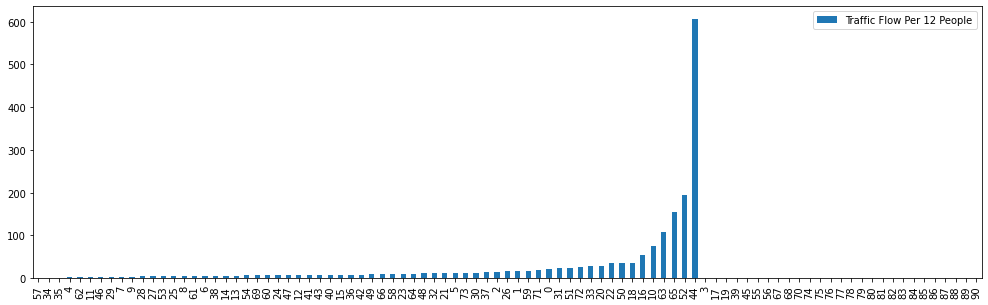

In [10]:
TrafficFlow = pd.DataFrame(TrafficAndPop[["Neighborhood", "Traffic Flow Per 12 People"]].sort_values(by = "Traffic Flow Per 12 People"))
TrafficFlow.plot.bar(figsize=(17, 5))

As we can see, our data has great disparities between the maximum and minimum values for the traffic flow, so when we create the map, we will use a log scale to normalize the data to make the differences more visible.

In [11]:
#Let's read in the shape file
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

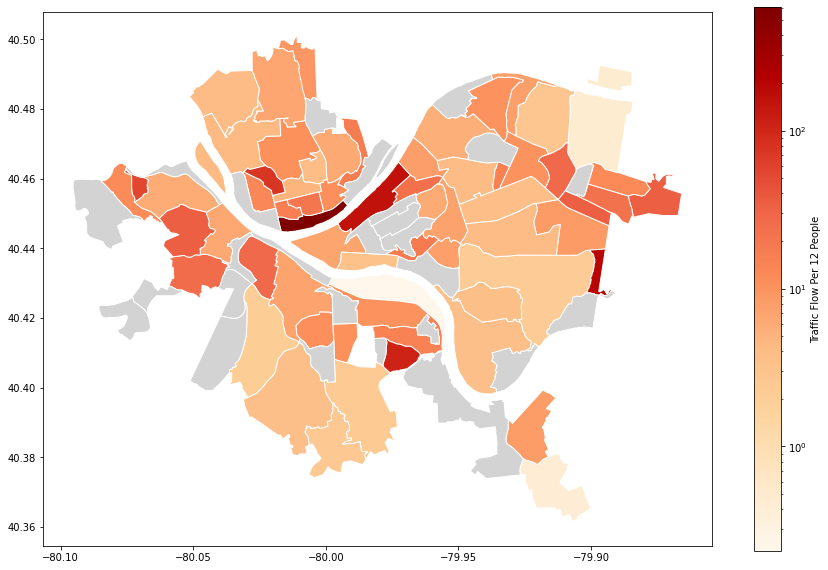

In [12]:
#Now let's format our map to insert our data
Traffic_Flow_Map = neighborhoods.merge(TrafficAndPop, how = "left", left_on = "hood", right_on = "Neighborhood")
Traffic_Flow_Map.plot(column= "Traffic Flow Per 12 People", 
               cmap= "OrRd",              
               edgecolor="white",        
               legend=True,             
               legend_kwds={'label': "Traffic Flow Per 12 People"}, 
               figsize=(15, 10),         
               missing_kwds={"color": "lightgrey"},
               norm = matplotlib.colors.LogNorm(vmin = Traffic_Flow_Map["Traffic Flow Per 12 People"].min(), vmax = Traffic_Flow_Map["Traffic Flow Per 12 People"].max())
               )

By this map, we can see that areas further away from the center of the city generally have lower traffic flows and thus will allow for better racing.

In [13]:
#Look at the definite lowest values for the traffic flow
TrafficAndPop.sort_values(by="Traffic Flow Per 12 People").head(10)

Neighborhood  Average Daily Car Traffic  Total Population  \
57          South Side Flats                 115.000000            6292.0   
34             Lincoln Place                 126.000000            3499.0   
35  Lincoln-Lemington-Belmar                 195.000000            4955.0   
4                  Beechview                1418.333333            8078.0   
62       Squirrel Hill South                3050.076923           16042.0   
11                   Carrick                1969.571429           10122.0   
46                 Overbrook                 777.000000            3682.0   
29             Highland Park                1564.733333            6810.0   
7                      Bluff                1788.333333            6294.0   
9                  Brookline                3914.400000           13160.0   

    Traffic Flow Per 12 People  
57                    0.219326  
34                    0.432123  
35                    0.472250  
4                     2.106957  
62                    2.281569  
11                    2.334999  
46                    2.532319  
29                    2.757239  
7                     3.409596  
9                     3.569362

By being able to collect the average car traffic counts for each neighborhood, comparing it to population counts of each neighborhood, I was able to determine which neighborhoods would be the least congested traffic-wise and would be best suited for real life Mario Kart.

Our top three Pittsburgh neighborhoods based on traffic congestion per 12 people were:

1. South Side Flats with a 0.22 flow ratio
2. Lincoln Place with a 0.43 flow ratio
3. Lincoln-Lemington-Belmar with a 0.47 flow ratio
4. Beechview with 2.11 flow ratio
5. Squirrel Hill South 2.28 flow ratio

---